# Optimizer Example
Jena Climate RNN example showing comparison between optimizers.
This is a regression model

Richard Henry, 16-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.16.2'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

# Jena RNN
Here we compare Adam to optimizers which appeared *after* Adam.

Adapted from Keras Documentation.
https://www.tensorflow.org/guide/keras/working_with_rnns

In [5]:
# Load Data (Already cleaned and decimated)
df3=pd.read_csv('dataset/Jena_climate/cleanJena.csv')

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70092 entries, 0 to 70091
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       70092 non-null  float64
 1   T (degC)       70092 non-null  float64
 2   Tdew (degC)    70092 non-null  float64
 3   VPact (mbar)   70092 non-null  float64
 4   max. wv (m/s)  70092 non-null  float64
 5   year           70092 non-null  int64  
 6   month          70092 non-null  int64  
 7   day            70092 non-null  int64  
 8   hour           70092 non-null  int64  
 9   NSwind         70092 non-null  float64
 10  EWwind         70092 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 5.9 MB


In [7]:
df3.describe()

,p (mbar),T (degC),Tdew (degC),VPact (mbar),max. wv (m/s),year,month,day,hour,NSwind,EWwind
count,70092.000000,70092.000000,70092.000000,70092.000000,70092.000000,70092.000000,70092.000000,70092.000000,70092.000000,70092.000000,70092.000000
mean,989.213025,9.449504,4.955497,9.533567,3.533703,2012.496975,6.517306,15.713591,11.500499,-0.628432,-0.411247
std,8.358157,8.422546,6.730988,4.184350,2.338343,2.289782,3.448345,8.799172,6.921791,1.985678,1.551204
min,918.500000,-22.760000,-24.800000,0.810000,0.000000,2009.000000,1.000000,1.000000,0.000000,-11.041287,-7.227855
25%,984.200000,3.350000,0.240000,6.210000,1.760000,2010.000000,4.000000,8.000000,6.000000,-1.471652,-1.367127
50%,989.580000,9.420000,5.210000,8.860000,2.960000,2012.000000,7.000000,16.000000,12.000000,-0.634275,-0.301333
75%,994.720000,15.470000,10.070000,12.352500,4.740000,2014.000000,10.000000,23.000000,17.000000,0.302326,0.446375
max,1015.290000,37.280000,22.940000,28.040000,20.330000,2017.000000,12.000000,31.000000,23.000000,8.173613,7.430575


In [8]:
# Model / data parameters
blk_len=30*24      #Look back at a month of data
stp_len=24         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=90*24      #batch size of 3 months
epo_len=50         #50 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
# This is visual basic code transcribed into python
# It works,but like VB6, it is slooooow
# surely there is a better way....
for i in range(cut_len):
    for j in range(blk_len):
        for k in range(col_len):
            xTrain[i][j][k]=xAll[i+j][k]

CPU times: total: 4min 4s
Wall time: 4min 11s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [11]:
# Build & train model function
def model_build(myOpti):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len)),
            fixMe,
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(1,
                           activation='linear')
        ]
    )
    model.compile(loss='mean_squared_error',
                  optimizer=myOpti,
                  metrics=['mean_absolute_error'])
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    myPre=model.predict(xTrain)
    return myHis,myPre

### First Model, Adam

In [12]:
%%time
h0,p0=model_build('adam')

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - loss: 136.3746 - mean_absolute_error: 9.6919 - val_loss: 97.0222 - val_mean_absolute_error: 7.8903
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 62.3823 - mean_absolute_error: 6.2587 - val_loss: 54.6054 - val_mean_absolute_error: 5.7758
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - loss: 36.5685 - mean_absolute_error: 4.6656 - val_loss: 38.3732 - val_mean_absolute_error: 4.7603
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 27.1883 - mean_absolute_error: 3.9871 - val_loss: 31.2245 - val_mean_absolute_error: 4.2467
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - loss: 22.4197 - mean_absolute_error: 3.5909 - val_loss: 25.3815 - val_mean_absolute_error: 3.7659
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - loss: 18.7706 - mean_absolute_error: 3.2652 - val_loss: 21.7633 - val_mean_absolute_error: 3.4870
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - loss: 16.2175 - mean_absolute_error: 3.0326 - 

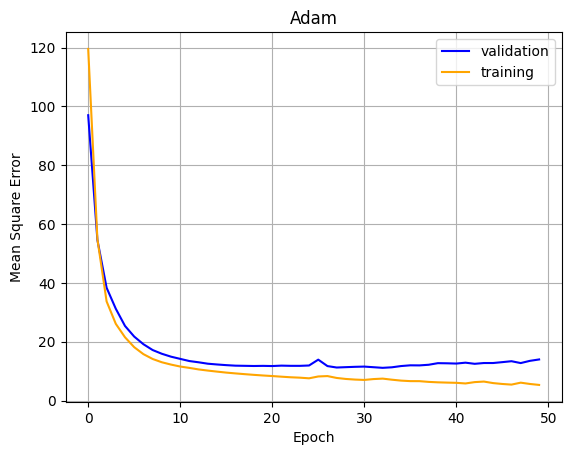

In [13]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h0.history['loss'], color='orange')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam')
plt.grid()
plt.show()

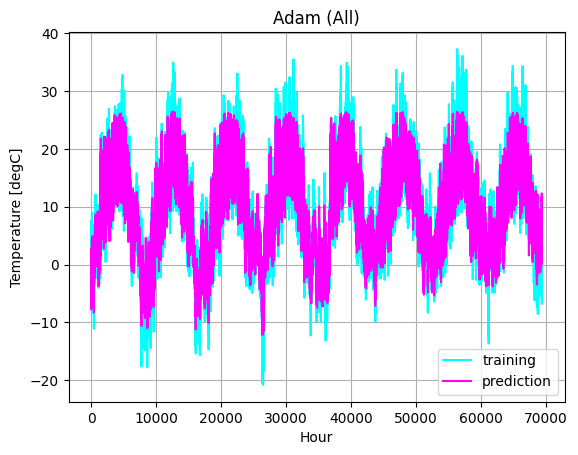

In [14]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam (All)')
plt.grid()
plt.show()

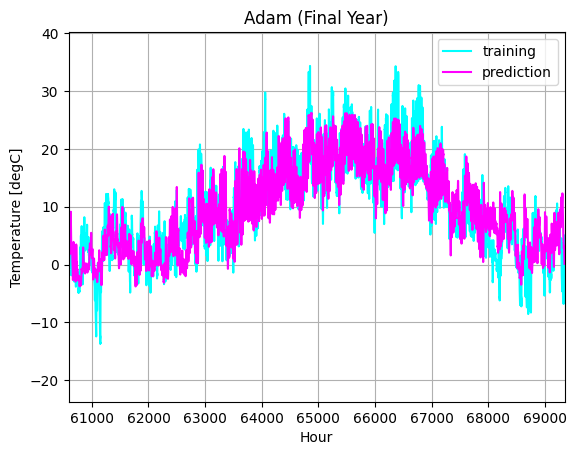

In [15]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam (Final Year)')
plt.grid()
plt.xlim([60588,69348])
plt.show()

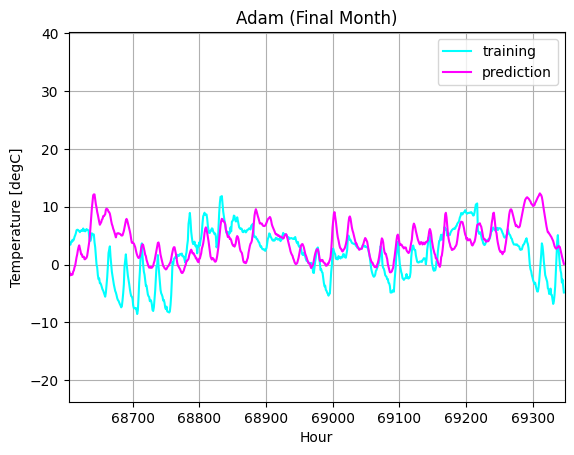

In [16]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam (Final Month)')
plt.grid()
plt.xlim([68604,69348])
plt.show()

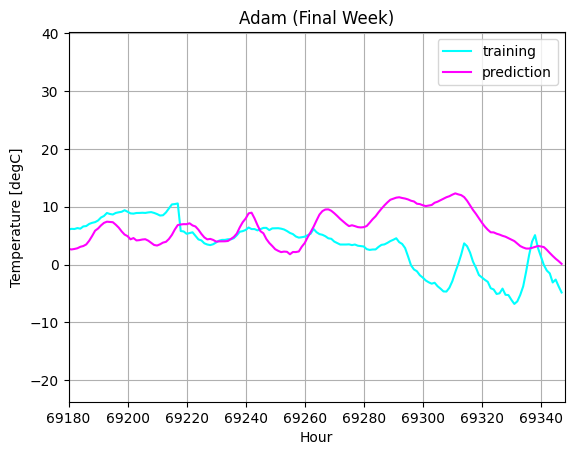

In [17]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam (Final Week)')
plt.grid()
plt.xlim([69180,69348])
plt.show()

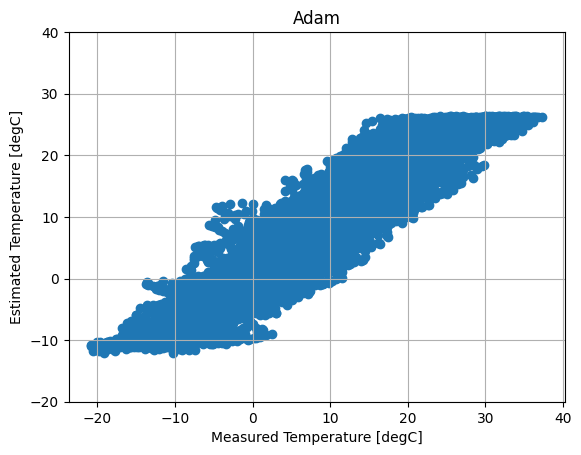

In [18]:
plt.scatter(y_train,p0.flatten())
plt.ylabel('Estimated Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam')
plt.grid()
plt.ylim([-20,40])
plt.show()

#### Commentary
Lorem Ipsum
### Second Model, Adam + Weight Decay

In [19]:
%%time
h1,p1=model_build('adamw')

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - loss: 139.9378 - mean_absolute_error: 9.7757 - val_loss: 101.8003 - val_mean_absolute_error: 8.1614
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - loss: 62.0954 - mean_absolute_error: 6.2129 - val_loss: 51.3815 - val_mean_absolute_error: 5.5708
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - loss: 35.0931 - mean_absolute_error: 4.5650 - val_loss: 36.7716 - val_mean_absolute_error: 4.6325
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - loss: 26.9258 - mean_absolute_error: 3.9562 - val_loss: 29.2228 - val_mean_absolute_error: 4.0623
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - loss: 22.2841 - mean_absolute_error: 3.5854 - val_loss: 24.6280 - val_mean_absolute_error: 3.7011
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - loss: 19.0375 - mean_absolute_error: 3.3004 - val_loss: 21.3114 - val_mean_absolute_error: 3.4477
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - loss: 16.7023 - mean_absolute_error: 3.0908 -

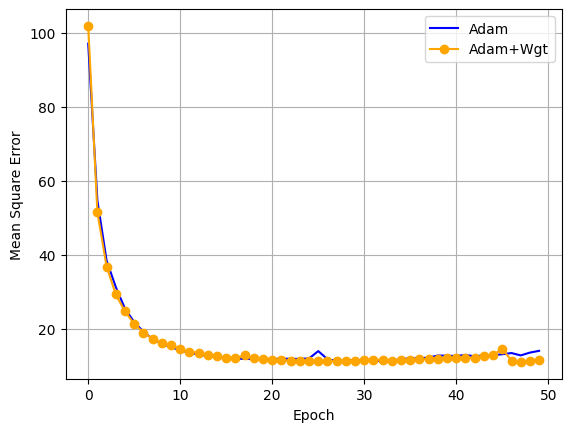

In [20]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h1.history['val_loss'], color='orange',marker='o')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt'])
plt.grid()
plt.show()

#### Commentary
Lorem Impsum
### Third Model, AdaFactor

In [21]:
%%time
h2,p2=model_build('adafactor')

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - loss: 155.7415 - mean_absolute_error: 10.3074 - val_loss: 194.2842 - val_mean_absolute_error: 11.6337
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - loss: 151.7420 - mean_absolute_error: 10.1666 - val_loss: 189.8039 - val_mean_absolute_error: 11.4868
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 147.5942 - mean_absolute_error: 10.0170 - val_loss: 184.9783 - val_mean_absolute_error: 11.3246
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 142.9631 - mean_absolute_error: 9.8454 - val_loss: 179.5511 - val_mean_absolute_error: 11.1365
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 137.5504 - mean_absolute_error: 9.6380 - val_loss: 173.0572 - val_mean_absolute_error: 10.9039
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 130.8888 - mean_absolute_error: 9.3732 - val_loss: 164.7370 - val_mean_absolute_error: 10.5962
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 122.4377 - mean_absol

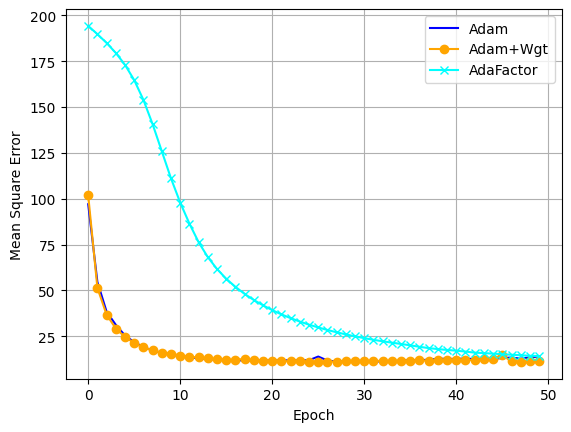

In [22]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','AdaFactor'])
plt.grid()
plt.show()

#### Commentary
Lorem Impsum
### Fourth Model, LION

In [23]:
%%time
h3,p3=model_build('lion')

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - loss: 136.0823 - mean_absolute_error: 9.6452 - val_loss: 91.5132 - val_mean_absolute_error: 7.6539
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - loss: 64.7954 - mean_absolute_error: 6.4649 - val_loss: 54.0224 - val_mean_absolute_error: 5.8235
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 38.7614 - mean_absolute_error: 4.9046 - val_loss: 36.1314 - val_mean_absolute_error: 4.6104
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - loss: 27.3049 - mean_absolute_error: 4.0089 - val_loss: 31.2288 - val_mean_absolute_error: 4.2209
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 29.8738 - mean_absolute_error: 4.1856 - val_loss: 26.6890 - val_mean_absolute_error: 3.9233
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - loss: 23.5597 - mean_absolute_error: 3.7672 - val_loss: 23.1918 - val_mean_absolute_error: 3.6660
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - loss: 24.0377 - mean_absolute_error: 3.8179 - v

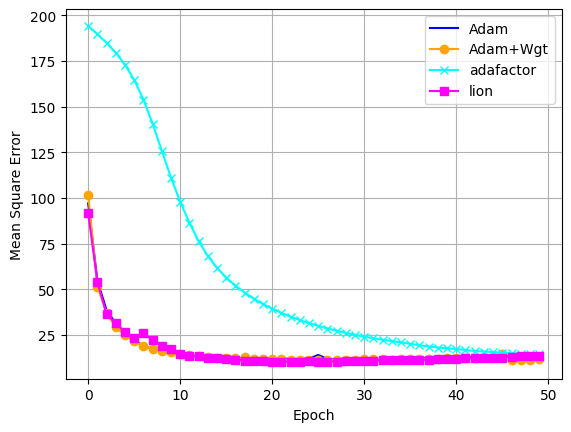

In [24]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.plot(h3.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','adafactor','lion'])
plt.grid()
plt.show()

#### Commentary
Lorem Ipsum
# Conclusions
Blah blah blah